In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import mylibrary.nnlib as tnn
import mylibrary.dynamicnnlib as tdnn
import mylibrary.datasets as datasets

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

## Loading the dataset

In [2]:
mnist = datasets.MNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

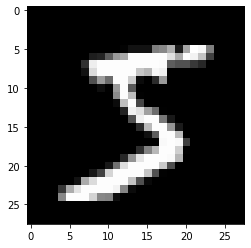

In [3]:
plt.imshow(train_data[0].reshape(28,28), cmap='gray')

## Training Neural Network

In [4]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 300
EPOCHS = 10

train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label)

In [5]:
optimizer = tnn.Adam(learning_rate)
net = tnn.AutoForm(new_layers=True)
layer1 = tnn.NonLinearLayer(input_size, 100, activation=tnn.LeakyRelu(), optimizer=optimizer)
layer2 = tnn.NonLinearLayer(100, 25, activation=tnn.LeakyRelu(), optimizer=optimizer)
layer3 = tnn.NonLinearLayer(25, 10, optimizer=optimizer)

In [6]:
accuracy_list = []

In [8]:
for epoch in range(EPOCHS):
    
    for index in range(train_size // batch_size):
        
        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        
        yout = net.forward(train_x)

        dy = tnn.SoftmaxCrossEntropy.del_loss(yout, train_y)
        loss = tnn.SoftmaxCrossEntropy.loss(yout, train_y)

        dx = net.backward(dy)

        net.update()

        if index % 100 == 0:
            print('\nTRAIN',index, '-> ', loss)

    yout = net.forward(train_data)
    outputs = tnn.Logits.logit_to_index(yout)
    correct = (outputs == np.array(train_label_)).sum()

    accuracy = correct / len(train_label_) * 100.
    print('EPOCH = ',epoch,'accuracy = ', accuracy)
    print(correct, '/', len(train_label_))

    yout = net.forward(test_data)
    outputs = tnn.Logits.logit_to_index(yout)
    correct = (outputs == np.array(test_label_)).sum()

    accuracy_ = correct / len(test_label_) * 100.
    print('   TEST  ','accuracy = ', accuracy_)
    print(correct, '/', len(test_label_))  
    
    accuracy_list.append((accuracy, accuracy_))


TRAIN 0 ->  7.270027763574653

TRAIN 100 ->  7.276578491289876
EPOCH =  0 accuracy =  95.29166666666666
57175 / 60000
   TEST   accuracy =  95.12
9512 / 10000

TRAIN 0 ->  7.264689971348404

TRAIN 100 ->  7.270618177923096
EPOCH =  1 accuracy =  95.57333333333334
57344 / 60000
   TEST   accuracy =  95.28999999999999
9529 / 10000

TRAIN 0 ->  7.259747007781514

TRAIN 100 ->  7.265525000031682
EPOCH =  2 accuracy =  95.84666666666666
57508 / 60000
   TEST   accuracy =  95.47
9547 / 10000

TRAIN 0 ->  7.255457146127117

TRAIN 100 ->  7.261072996738339
EPOCH =  3 accuracy =  96.08
57648 / 60000
   TEST   accuracy =  95.69
9569 / 10000

TRAIN 0 ->  7.251909057562786

TRAIN 100 ->  7.256969861218923
EPOCH =  4 accuracy =  96.28666666666666
57772 / 60000
   TEST   accuracy =  95.88
9588 / 10000

TRAIN 0 ->  7.248576315340697

TRAIN 100 ->  7.253118349089488
EPOCH =  5 accuracy =  96.50999999999999
57906 / 60000
   TEST   accuracy =  96.03
9603 / 10000

TRAIN 0 ->  7.24580704955657

TRAIN 100

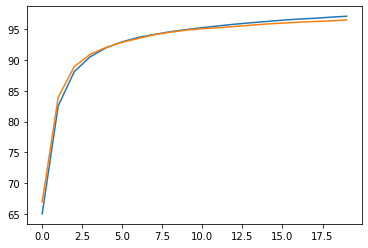

In [9]:
accuracies = np.array(accuracy_list)
plt.plot(accuracies[:,0], label='train')
plt.plot(accuracies[:,1], label='test')

# Sorting the neurons

In [10]:
n_neurons = [784,100,25,10]
space_D = 1
layers = [layer1, layer2, layer3]

### Defining helper functions

In [17]:
def initialize_positions(layers, n_neurons, space_D):
    positions = []
    for i, neurons in enumerate(n_neurons):
        pos = np.random.uniform(size=(neurons, space_D))
        positions.append(pos)
    return positions

In [18]:
def normalize_positions(positions):
    mini, maxi = positions[0].min(axis=0), positions[0].max(axis=0)
    divisor = maxi-mini

    for i in range(len(positions)):
        positions[i] = (positions[i]-mini)/divisor
    return positions

# def normalize_positions(positions):
#     mini = 9e9
#     maxi = -9e9
#     for i in range(len(positions)):
#         mi, ma = positions[i].min(), positions[i].max()
#         if mi<mini:
#             mini=mi
#         if ma>maxi:
#             maxi=ma
    
#     divisor = maxi-mini
#     for i in range(len(positions)):
#         positions[i] = (positions[i]-mini)/divisor
#     return positions

In [28]:
def compute_del_positions(positions, layers):
    del_positions = [0]*len(positions)
    
    for i in range(len(layers)+1):
        if i == 0:
#             wts = layers[i].weights**2
#             wts = layers[i].weights
            wts = np.abs(layers[i].weights)
            pos = positions[i+1]
        elif i == len(layers):
#             wts = (layers[i-1].weights**2).T
#             wts = (layers[i-1].weights).T
            wts = np.abs(layers[i-1].weights.T)
            pos = positions[i-1]
        else:
#             wts_next = layers[i].weights**2
#             wts_next = layers[i].weights
            wts_next = np.abs(layers[i].weights)
#             wts_prev = (layers[i-1].weights**2).T
#             wts_prev = (layers[i-1].weights).T
            wts_prev = np.abs(layers[i-1].weights.T)
            wts = np.concatenate((wts_prev, wts_next), axis=1)
            pos = np.concatenate((positions[i-1], positions[i+1]), axis=0)

        scaler = wts.sum(axis=1, keepdims=True)
#         print(pos.shape, wts.shape, scaler.shape)
        del_pos = (wts/scaler)@pos
        new_pos = del_pos.sum(axis=1, keepdims=True)
        
#         if i == len(layers):
#             print(wts)
#             print(pos)
#             print(del_pos)
#             print(new_pos)
        
        del_positions[i] = - new_pos + positions[i]
    return del_positions

## Doing this iteratively

In [92]:
n_neurons = [784,100,25,10]
space_D = 1
layers = [layer1, layer2, layer3]

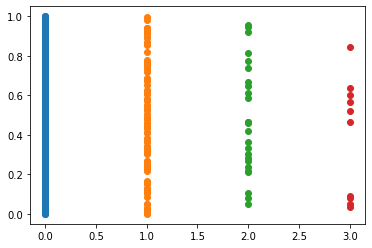

In [93]:
positions = initialize_positions(layers, n_neurons, space_D)
positions = normalize_positions(positions)

%matplotlib inline
for i, pos in enumerate(positions):
    plt.scatter([i]*len(pos), pos)

In [95]:
lr = 0.5

%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(1000):
    
    if epoch%1 == 0:
        ax.clear()
        for i, pos in enumerate(positions):
            ax.scatter([i]*len(pos), pos)
        fig.canvas.draw()
        plt.pause(0.1)
        
    positions = normalize_positions(positions)
    del_positions = compute_del_positions(positions, layers)
    for i in range(len(positions)-4, len(positions)):
        if i == 0:
            del_positions[i] /= 2
        positions[i] -= lr*del_positions[i]

TclError: can't invoke "update" command: application has been destroyed

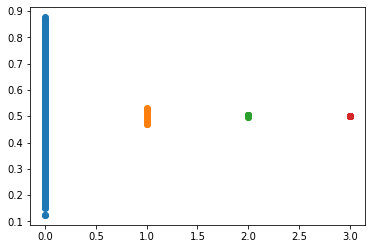

In [65]:
%matplotlib inline
for i, pos in enumerate(positions):
    plt.scatter([i]*len(pos), pos)

In [66]:
del_positions

[array([[ 0.10760582],
        [ 0.10781796],
        [-0.195836  ],
        [ 0.04304265],
        [ 0.12291128],
        [ 0.04136154],
        [-0.07882363],
        [-0.02919807],
        [-0.18572177],
        [ 0.03345423],
        [ 0.09165984],
        [-0.14201853],
        [ 0.11026089],
        [ 0.11829827],
        [ 0.05129748],
        [ 0.05894254],
        [-0.00860779],
        [ 0.18464049],
        [-0.09327156],
        [-0.22257437],
        [-0.0549283 ],
        [-0.05843975],
        [-0.08062826],
        [-0.03773653],
        [ 0.00893498],
        [ 0.12965256],
        [ 0.15649565],
        [ 0.16274487],
        [-0.18730672],
        [ 0.07399246],
        [-0.09913829],
        [-0.03345374],
        [-0.09943185],
        [-0.15846926],
        [ 0.1001582 ],
        [ 0.18270959],
        [-0.00059399],
        [-0.14852466],
        [-0.01921795],
        [ 0.13589761],
        [ 0.01632345],
        [-0.00139585],
        [-0.02963314],
        [-0

### Sorting in 2D

In [96]:
n_neurons = [784,100,25,10]
space_D = 2
layers = [layer1, layer2, layer3]

In [97]:
%matplotlib widget

positions = initialize_positions(layers, n_neurons, space_D)
positions = normalize_positions(positions)
    
fig = plt.figure()
ax = fig.gca(projection='3d')

for i, pos in enumerate(positions):
    ax.scatter([i]*len(pos), pos[:,0], pos[:,1], marker='o')
    
ax.set_xlabel('Depth')
ax.set_ylabel('X1')
ax.set_zlabel('X2')

Text(0.5, 0, 'X2')

In [98]:
lr = 0.5

%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(1000):
    
    if epoch%10 == 0:
        ax.clear()
        for i, pos in enumerate(positions):
            ax.scatter([i]*len(pos), pos[:,0], pos[:,1], marker='o')
        ax.set_xlabel('Depth')
        ax.set_ylabel('X1')
        ax.set_zlabel('X2')
        fig.canvas.draw()
        plt.pause(0.1)
        
    positions = normalize_positions(positions)
    del_positions = compute_del_positions(positions, layers)
#     del_positions[0] *= 0
    for i in range(len(positions)-1, len(positions)):
        positions[i] -= lr*del_positions[i]

TclError: can't invoke "update" command: application has been destroyed

Text(0.5, 0, 'X2')

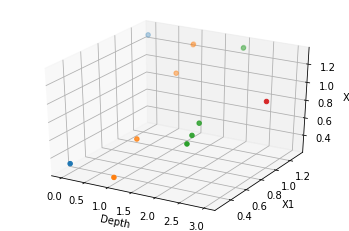

In [245]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')

for i, pos in enumerate(positions):
    ax.scatter([i]*len(pos), pos[:,0], pos[:,1], marker='o')
    
ax.set_xlabel('Depth')
ax.set_ylabel('X1')
ax.set_zlabel('X2')